<a href="https://colab.research.google.com/github/y3y-tech/CX4240_Project/blob/main/Stock_Predictor_Models_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# Install yfinance if you don't have it
# !pip install yfinance

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier


In [13]:
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0).rolling(window=window).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

def compute_macd(series, span_short=12, span_long=26, signal_span=9):
    ema_short = series.ewm(span=span_short, adjust=False).mean()
    ema_long = series.ewm(span=span_long, adjust=False).mean()
    macd_line = ema_short - ema_long
    signal_line = macd_line.ewm(span=signal_span, adjust=False).mean()
    return macd_line, signal_line

def compute_stochastic_oscillator(high, low, close, k_window=14, d_window=3):
    lowest_low = low.rolling(window=k_window).min()
    highest_high = high.rolling(window=k_window).max()
    stoch_k = 100 * (close - lowest_low) / (highest_high - lowest_low)
    stoch_d = stoch_k.rolling(window=d_window).mean()
    return stoch_k, stoch_d

In [14]:
def load_data_with_macro(ticker="^GSPC", start="2015-01-01", end="2024-01-01", prediction_horizon=5, big_move_threshold=0.01):
    # Download stock data
    df = yf.download(ticker, start=start, end=end)

    # Download macro indicators
    vix = yf.download('^VIX', start=start, end=end)
    tnx = yf.download('^TNX', start=start, end=end)

    # Feature Engineering
    df['Mid'] = (df['High'] + df['Low']) / 2
    df['Return'] = df['Close'].pct_change()
    df['Mid_Return'] = df['Mid'].pct_change()
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['Volatility'] = df['Return'].rolling(window=10).std()
    df['Momentum'] = df['Close'] - df['Close'].shift(5)
    df['RSI'] = compute_rsi(df['Close'])
    df['MACD'], df['MACD_signal'] = compute_macd(df['Close'])
    df['Stoch_K'], df['Stoch_D'] = compute_stochastic_oscillator(df['High'], df['Low'], df['Close'])

    # Merge macro features
    df['VIX_Close'] = vix['Close']
    df['TNX_Close'] = tnx['Close']

    # Predict multi-day future returns
    df['Future_Return'] = df['Close'].shift(-prediction_horizon) / df['Close'] - 1

    # Define labels: only predict big moves
    df['Target'] = np.where(df['Future_Return'] > big_move_threshold, 1,
                            np.where(df['Future_Return'] < -big_move_threshold, 0, np.nan))

    df.dropna(inplace=True)

    features = ['MA5', 'MA10', 'MA20', 'Volatility', 'Momentum', 'Return',
                'RSI', 'MACD', 'MACD_signal', 'Stoch_K', 'Stoch_D',
                'VIX_Close', 'TNX_Close']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[features])

    y = df['Target'].values.squeeze()
    raw_returns = df['Mid_Return'].values.squeeze()

    return np.array(X_scaled), y, raw_returns

In [18]:
def walk_forward_validation(X, y, raw_returns, window_size=200, step_size=5, threshold=0.6):
    results = []
    preds_all = []
    true_all = []

    for start in range(0, len(X) - window_size, step_size):
        end = start + window_size
        X_train, y_train = X[start:end], y[start:end]
        X_test, y_test = X[end:end+step_size], y[end:end+step_size]
        returns_test = raw_returns[end:end+step_size]

        if len(y_test) == 0:
            break

        model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
        model.fit(X_train, y_train)

        probs = model.predict_proba(X_test)[:, 1]
        preds = (probs > threshold).astype(int)

        preds_all.extend(preds)
        true_all.extend(y_test)

    return np.array(true_all), np.array(preds_all)

In [19]:
# Cumulative Return Plot
def plot_cumulative_returns(y_true, y_pred, raw_returns, step_size=5):
    # Build positions: 1 (long) if predict up, -1 (short) if predict down
    positions = 2 * y_pred - 1  # 1 if predict up, -1 if predict down

    # Align returns
    returns = raw_returns[-len(y_pred):]

    # Strategy returns
    strategy_returns = positions * returns
    cumulative_strategy_returns = np.cumsum(strategy_returns)

    # Buy and hold returns
    cumulative_buy_hold_returns = np.cumsum(returns)

    plt.figure(figsize=(14, 7))
    plt.plot(cumulative_strategy_returns, label="Strategy")
    plt.plot(cumulative_buy_hold_returns, label="Buy & Hold", linestyle="--")
    plt.title("Cumulative Returns: Strategy vs Buy & Hold")
    plt.xlabel("Days")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.show()

    return cumulative_strategy_returns, cumulative_buy_hold_returns

# Sharpe Ratio
def sharpe_ratio(returns, risk_free_rate=0.0):
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns)

# Maximum Drawdown
def max_drawdown(cumulative_returns):
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:20:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:20:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:20:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:20:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encode

Accuracy: 0.5825
Precision: 0.6898
Recall: 0.6102
F1-Score: 0.6476


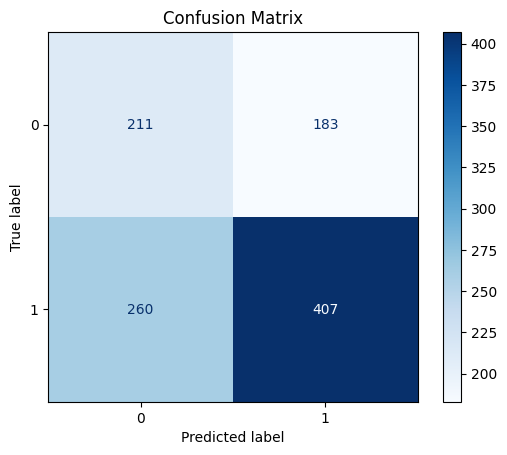

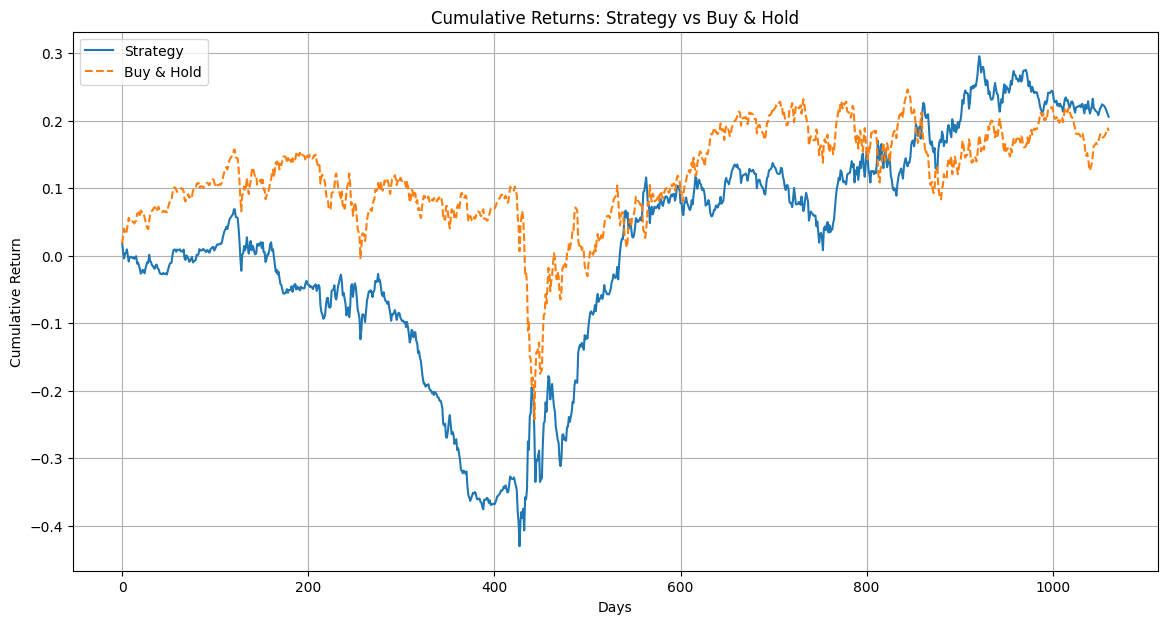

Strategy Sharpe Ratio: 0.0167
Strategy Maximum Drawdown: -7.2423


In [20]:
# Load Data
X, y, raw_returns = load_data_with_macro()

# Run Walk-Forward Validation
y_true, y_pred = walk_forward_validation(X, y, raw_returns)

# Evaluate Model
evaluate_model(y_true, y_pred)

# 📈 Plot Cumulative Returns
cumulative_strategy, cumulative_hold = plot_cumulative_returns(y_true, y_pred, raw_returns)

# 📈 Calculate Sharpe Ratio and Max Drawdown
strategy_sharpe = sharpe_ratio(np.diff(cumulative_strategy))
strategy_mdd = max_drawdown(cumulative_strategy)

print(f"Strategy Sharpe Ratio: {strategy_sharpe:.4f}")
print(f"Strategy Maximum Drawdown: {strategy_mdd:.4f}")

In [16]:
def evaluate_model(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:19:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:19:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:19:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:19:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encode

Accuracy: 0.5825
Precision: 0.6898
Recall: 0.6102
F1-Score: 0.6476


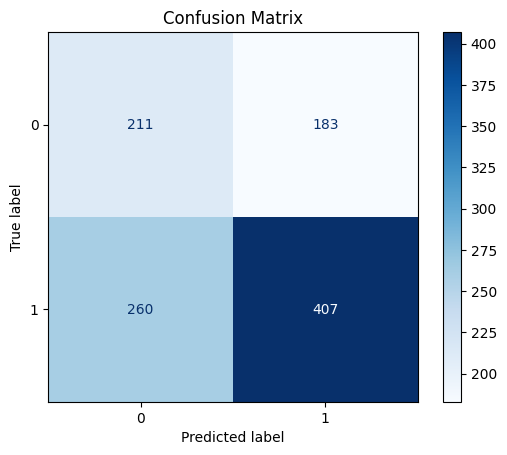

In [17]:
X, y, raw_returns = load_data_with_macro()

y_true, y_pred = walk_forward_validation(X, y, raw_returns)

evaluate_model(y_true, y_pred)